In [1]:
machine_name = "fan"

# Import Libaries

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil
import matplotlib.pyplot as plt

## Create directory management

In [3]:
# If dir not present creatre
pickel_dir = "saved_model"
if not os.path.exists(pickel_dir):
    os.makedirs(pickel_dir)

In [4]:
from sklearn.metrics import classification_report

def class_report(y_test, y_pred):
    target_names = []
    for i in y.unique():
        target_names.append(f"class {i}")
        
    try:
        y_true = y_test[0].tolist()
        
    except:
        y_true = y_test.tolist()
        
    y_pred = y_pred.tolist()
    print(classification_report(y_true, y_pred, target_names=target_names))

## Funnel feature

In [6]:
important_col =['is_normal', 'T_rms_mean', 'T_rms_std', 'T_zcr_mean',
                       'F_mel_mean', 'F_mel_std', 'F_mel_rms_mean', 'F_mel_rms_std',
                       'F_mfcc_mean', 'F_mfcc_std', 'F_flatness_mean',
                       'F_bandwidth_mean', 'F_bandwidth_std', 'F_contrast_mean',
                       'F_rolloff_mean', 'F_rolloff_std']

dataset = pd.read_csv(f'./dataset/processed_data/{machine_name}_all.csv.xz')
dataset = dataset[important_col]

## Split data

In [7]:
X = dataset.drop("is_normal", axis=1)
y = dataset["is_normal"]

from sklearn.model_selection import train_test_split

X_model, X_val, y_model, y_val  = train_test_split(X, y, test_size=0.1, random_state=1)

## Resample over sample

In [8]:
from imblearn.over_sampling import BorderlineSMOTE
X_resample, y_resample = BorderlineSMOTE().fit_resample(X_model, y_model.ravel())

y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=1)

## Random Forest Estimator 100

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [10]:
from sklearn.ensemble import RandomForestClassifier

no_estimators = 100

RF_classifier = RandomForestClassifier(random_state = 0, n_estimators = no_estimators, criterion = 'entropy')
RF_classifier.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [11]:
from sklearn.metrics import classification_report

print("************************  Test ************************")
y_pred = RF_classifier.predict(X_test)
class_report(y_test, y_pred)

print("************************  Validation ************************")
y_valid_pred = RF_classifier.predict(X_val)
class_report(y_val, y_valid_pred)

************************  Test ************************
              precision    recall  f1-score   support

     class 0       0.93      0.94      0.94      2198
     class 1       0.94      0.93      0.94      2203

    accuracy                           0.94      4401
   macro avg       0.94      0.94      0.94      4401
weighted avg       0.94      0.94      0.94      4401

************************  Validation ************************
              precision    recall  f1-score   support

     class 0       0.85      0.89      0.87       441
     class 1       0.96      0.94      0.95      1224

    accuracy                           0.93      1665
   macro avg       0.90      0.92      0.91      1665
weighted avg       0.93      0.93      0.93      1665



## Saving Machine model to predict abnormal or normal sound

In [12]:
filename = f'Predict_{machine_name}_sound_type.sav'
pickle.dump(RF_classifier, open(f"./{pickel_dir}/{filename}", 'wb'))

# load the model from disk
loaded_model = pickle.load(open(f"./{pickel_dir}/{filename}", 'rb'))
result = loaded_model.score(X_val, y_val)
print(round(result,2))

0.93


# 

## K-mean clustering
* Sub catogorize abnormal dataset.

## Using the elbow method to find the optimal number of clusters

In [13]:
cluster_dataset = pd.read_csv(f'./dataset/processed_data/{machine_name}_all.csv.xz')
cluster_dataset = cluster_dataset[important_col]
abnormal_dataset = cluster_dataset[cluster_dataset.is_normal == 0]
dataset = abnormal_dataset.drop(columns=["is_normal"])

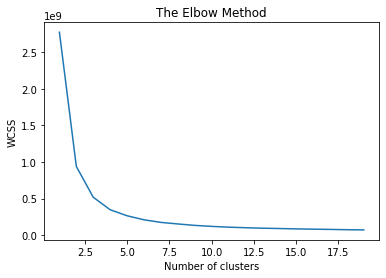

In [14]:
from sklearn.cluster import KMeans
wcss = []
random_S = 0
total_test = 20
for i in range(1, total_test):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = random_S)
    kmeans.fit(dataset)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, total_test), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS');

## Training the K-Means model on the dataset

In [15]:
no_cluster = 4
kmeans = KMeans(n_clusters = no_cluster, init = 'k-means++', random_state = random_S)
y_kmeans = kmeans.fit_predict(dataset)

## Placing types of abnormal sound

In [16]:
abnormal_dataset = abnormal_dataset.drop(columns=["is_normal"])
abnormal_dataset["is_normal"] = y_kmeans.tolist()

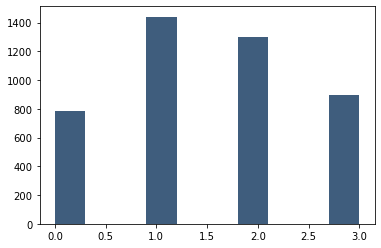

In [17]:
plt.hist(abnormal_dataset.is_normal, color='#3F5D7D');

## Split data

In [18]:
X = abnormal_dataset.drop("is_normal", axis=1)
y = abnormal_dataset.is_normal

from sklearn.model_selection import train_test_split

X_model, X_val, y_model, y_val  = train_test_split(X, y, test_size=0.1, random_state=1) # 0.25 x 0.8 = 0.2

In [19]:
print(X_model.shape)
print(y_model.shape)

(3982, 15)
(3982,)


## Resample over sample

In [20]:
from imblearn.over_sampling import BorderlineSMOTE
X_resample, y_resample = BorderlineSMOTE().fit_resample(X_model, y_model.ravel())

y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=1)

[1 0 2 3]


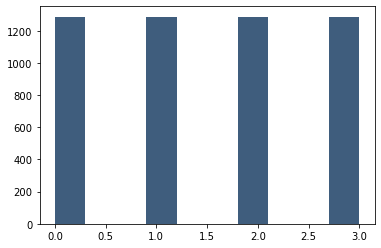

In [21]:
print(y_resample[0].unique())
plt.hist(y_resample, color='#3F5D7D');

## XGBoost Classifier

In [22]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train.values.ravel())

[10:20:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
print("************************ Test ************************")
y_pred = xgb_classifier.predict(X_test)
class_report(y_test, y_pred)

print("************************ Validation ************************")
y_val_pred = xgb_classifier.predict(X_val)
class_report(y_val, y_val_pred)

************************ Test ************************
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99       252
     class 2       1.00      0.98      0.99       255
     class 1       0.99      0.99      0.99       275
     class 3       0.99      1.00      1.00       249

    accuracy                           0.99      1031
   macro avg       0.99      0.99      0.99      1031
weighted avg       0.99      0.99      0.99      1031

************************ Validation ************************
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98        71
     class 2       0.99      0.98      0.99       153
     class 1       0.99      0.98      0.98       122
     class 3       0.98      0.99      0.98        97

    accuracy                           0.98       443
   macro avg       0.98      0.99      0.98       443
weighted avg       0.98      0.98      0.98       443



## Saving Machine model to predict abnormal sound type

In [24]:
filename = f'Predict_{machine_name}_abnormal_sound_type.sav'
pickle.dump(xgb_classifier, open(f"./{pickel_dir}/{filename}", 'wb'))

# load the model from disk
loaded_model = pickle.load(open(f"./{pickel_dir}/{filename}", 'rb'))
result = loaded_model.score(X_val, y_val)
print(round(result,2))

0.98
